In [9]:
# ==== 0. Imports ====
import os, json, random, ast
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

try:
    import seaborn as sns
    sns.set(style="whitegrid")
except ImportError:
    print("Seaborn 未安装，图形会用 Matplotlib 默认样式")

# 常量（按需修改）
DATA_DIR   = Path("/home/mtang/vslib/mlpc2025_Team_Laborer/MLPC2025_classification")      # 数据根目录
META_FILE  = DATA_DIR/"metadata.csv"
ANNO_FILE  = DATA_DIR/"annotations.csv"
LABEL_DIR  = DATA_DIR/"labels"
FEAT_DIR   = DATA_DIR/"audio_features"

RNG_SEED = 42
np.random.seed(RNG_SEED)
random.seed(RNG_SEED)


In [10]:
# ==== 1.1 读取 & 基本信息 ====
meta = pd.read_csv(META_FILE)

# 计算录音时长；NaN 用 0 填充
meta["start_time_s"] = meta["start_time_s"].fillna(0.)
meta["duration"] = meta["end_time_s"] - meta["start_time_s"]
print(f"共有 {len(meta)} 条录音；平均时长 = {meta['duration'].mean():.2f} s")

meta.head()


共有 8230 条录音；平均时长 = 22.37 s


,filename,keywords,freesound_id,sound_link,manufacturer,license,title,description,num_downloads,geotag,start_time_s,end_time_s,duration
0,321771.mp3,"Interior, AMB, Italy, Distant, Speech, Reverb",321771,https://freesound.org/people/Skjor1/sounds/321...,Skjor1,http://creativecommons.org/publicdomain/zero/1.0/,Interior Ambience + Distant Reverberant Speech...,Interior Ambience + Distant Reverberant Speech...,120,NaN,5.200,27.179,21.979
1,451371.mp3,"kids, throaty, crowd, India, distant, traffic,...",451371,https://freesound.org/people/kyles/sounds/451371/,kyles,http://creativecommons.org/publicdomain/zero/1.0/,election rally crowd and speech with distant t...,election rally crowd and speech with distant t...,122,NaN,120.800,144.984,24.184
2,199414.mp3,"broadcast, speech, radio",199414,https://freesound.org/people/martinimeniscus/s...,martinimeniscus,http://creativecommons.org/publicdomain/zero/1.0/,"Old Radio Speech Background, higher FF125.aif",Background noise for an old radio broadcast sp...,391,NaN,102.003,130.921,28.918
3,410952.mp3,"loop2017, atmos, dolby, speech, ableton",410952,https://freesound.org/people/lietoofine/sounds...,lietoofine,https://creativecommons.org/licenses/by/4.0/,dolby atmos speech.wav,dolby atmos speech @Loop2017,193,52.479543 13.500279,31.330,54.021,22.691
4,203908.mp3,"dr-40, project, speech, student, italian, reci...",203908,https://freesound.org/people/s9ames/sounds/203...,s9ames,http://creativecommons.org/licenses/by/3.0/,bologna speech Italian2,recorded with a tascam dr-40 in a sound studio...,526,NaN,29.200,45.689,16.489


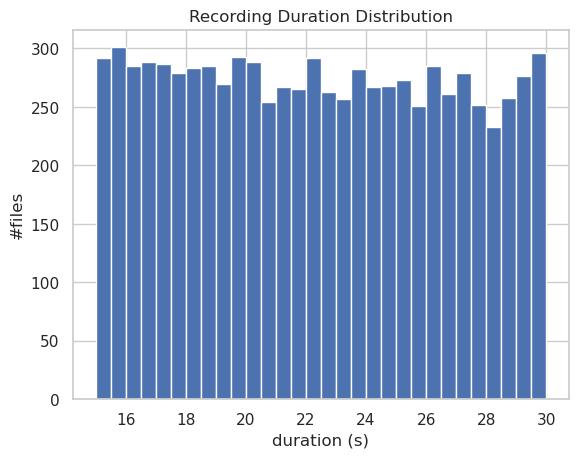

In [11]:
plt.hist(meta["duration"], bins=30)
plt.xlabel("duration (s)"); plt.ylabel("#files")
plt.title("Recording Duration Distribution")
plt.show()


In [12]:
from collections import Counter
kw_counter = Counter()

for kw_string in meta["keywords"].dropna():
    # 去掉首尾空格再 split
    kw_counter.update([k.strip() for k in kw_string.split(",") if k.strip()])

kw_df = (pd.DataFrame(kw_counter.items(), columns=["keyword","count"])
           .sort_values("count", ascending=False)
           .reset_index(drop=True))
kw_df.head(20)


,keyword,count
0,field-recording,2284
1,ambience,864
2,water,743
3,nature,721
4,ambient,628
5,rain,559
6,engine,514
7,birds,460
8,wind,437
9,city,416


In [13]:
anno = pd.read_csv(ANNO_FILE)
# categories 字段是形如 "['Alarm']" 的字符串 → 解析成 list
anno["cat_list"] = anno["categories"].apply(ast.literal_eval)

print("注释条数:", len(anno))
print("前 3 条:")
display(anno[["filename","text","cat_list"]].head())

# 统计出现频次
cat_counter = Counter()
anno["cat_list"].apply(cat_counter.update)
print("前 10 个注释类别:", cat_counter.most_common(10))


注释条数: 27552
前 3 条:


,filename,text,cat_list
0,117126.mp3,An alarm is ringing loudly and repeatedly nearby.,[Alarm]
1,117126.mp3,An alarm is ringing repeatedly nearby.,[Alarm]
2,118234.mp3,An alarm clock is beeping continuously.,"[Alarm, Beep/Bleep]"
3,118234.mp3,An alarm clock is beeping continuously.,"[Alarm, Beep/Bleep]"
4,119173.mp3,A car alarm sounds loudly in a steady pattern.,"[Alarm, Car]"


前 10 个注释类别: [('Bird Chirp', 2956), ('Speech', 2664), ('Dog Bark', 1446), ('Car', 1266), ('Wind', 1146), ('Bell', 960), ('Insect Buzz', 884), ('Rain', 835), ('Beep/Bleep', 829), ('Footsteps', 798)]


In [14]:
# ==== 3.1 聚合标签 ====
from collections import defaultdict, Counter
frame_cnt = Counter()
file_cnt  = Counter()

for lbl_path in LABEL_DIR.glob("*_labels.npz"):
    arrs = np.load(lbl_path, allow_pickle=False)
    for cls in arrs.files:
        y = arrs[cls]
        positives = int(np.count_nonzero(y))
        if positives:
            frame_cnt[cls] += positives
            file_cnt[cls]  += 1

label_df = (pd.DataFrame({
                "class": list(frame_cnt.keys()),
                "pos_frames": [frame_cnt[c] for c in frame_cnt],
                "num_files": [file_cnt[c] for c in frame_cnt],
            })
            .sort_values("pos_frames", ascending=False)
            .reset_index(drop=True))
label_df.head()


,class,pos_frames,num_files
0,Speech,152342,1232
1,Bird Chirp,129927,947
2,Wind,115555,697
3,Rain,108146,570
4,Car,100265,696


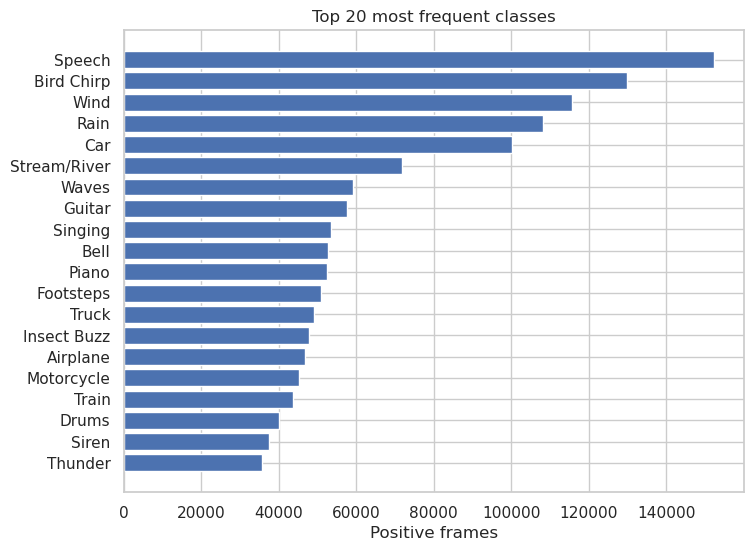

In [15]:
TOP_N = 20
plt.figure(figsize=(8,6))
plt.barh(label_df["class"][:TOP_N][::-1],
         label_df["pos_frames"][:TOP_N][::-1])
plt.xlabel("Positive frames"); plt.title(f"Top {TOP_N} most frequent classes")
plt.show()


In [16]:
# 策略：帧数≥所有正帧 1% 的类 + 排名前 15 至少保证样本丰富
total_frames = sum(frame_cnt.values())
thr = 0.01 * total_frames           # 1% 阈值

subset = label_df.query("pos_frames >= @thr").head(15)["class"].tolist()
print("最终类别子集（{} 类）:".format(len(subset)), subset)

# 保存到项目根目录
with open("class_subset.json","w") as f:
    json.dump(subset, f, indent=2, ensure_ascii=False)


最终类别子集（15 类）: ['Speech', 'Bird Chirp', 'Wind', 'Rain', 'Car', 'Stream/River', 'Waves', 'Guitar', 'Singing', 'Bell', 'Piano', 'Footsteps', 'Truck', 'Insect Buzz', 'Airplane']


In [20]:
# ==== 4.1 Sampling (robust) ====
from collections import defaultdict
from tqdm import tqdm

SAMPLE_FRAMES = 50_000
sampled       = defaultdict(list)
pbar          = tqdm(total=SAMPLE_FRAMES, desc="Sampling MFCC frames")

while sum(len(v) for v in sampled.values()) < SAMPLE_FRAMES:
    # 随机拿 1 条录音（无需 random_state）
    row = meta.sample(1).iloc[0]

    # feature 文件名：把 .mp3 → .npz
    ffile = FEAT_DIR / f"{Path(row['filename']).stem}.npz"
    if not ffile.exists():
        continue

    arrs = np.load(ffile)
    if "mfcc" not in arrs.files:
        continue

    mfcc = arrs["mfcc"]          # shape (T, n_mfcc)
    if mfcc.size == 0:
        continue

    # 每文件抽 ≤10 帧
    take = min(10, mfcc.shape[0],
               SAMPLE_FRAMES - sum(len(v) for v in sampled.values()))
    idx  = np.random.choice(mfcc.shape[0], size=take, replace=False)
    sampled["mfcc"].append(mfcc[idx])

    pbar.update(take)

pbar.close()

mfcc_sample = np.concatenate(sampled["mfcc"], axis=0)  # (N, n_mfcc)
print("最终采样帧数:", mfcc_sample.shape[0])


Sampling MFCC frames: 499955it [00:47, 10586.39it/s]                         

最终采样帧数: 499955


## Data-Inspection Summary

### 1. Metadata  
* **Recording count:** **8 230** files  
* **Average duration:** **22.37 s**  
* **Duration distribution:** fairly uniform between **15 – 30 s**  
  <br>*(see histogram above)*  

| rank | keyword | count |
|:---|:---|---:|
| 1 | field-recording | 2 284 |
| 2 | ambience | 864 |
| 3 | water | 743 |
| 4 | nature | 721 |
| 5 | ambient | 628 |
| 6 | rain | 559 |
| 7 | engine | 514 |
| 8 | birds | 460 |
| 9 | wind | 437 |
|10 | city | 416 |

### 2. Text Annotations  
* **Annotation rows:** **27 552**  
* **Most frequent categories:**  
  `Bird Chirp`, `Speech`, `Dog Bark`, `Car`, `Wind`, `Bell`, `Insect Buzz`, `Rain`, `Beep/Bleep`, `Footsteps`

### 3. Frame-Level Labels  
Top-5 positive-frame classes  

| class | pos frames | num files |
|:---|---:|---:|
| Speech | 152 342 | 1 232 |
| Bird Chirp | 129 927 | 947 |
| Wind | 115 555 | 697 |
| Rain | 108 146 | 570 |
| Car | 100 265 | 696 |

*Bar chart of top-20 classes shown above.*

### 4. Chosen Target Class Sub-Set  
Based on ≥ 1 % frame share **and** top-15 ranking:

`['Speech', 'Bird Chirp', 'Wind', 'Rain', 'Car',  
  'Stream/River', 'Waves', 'Guitar', 'Singing', 'Bell',  
  'Piano', 'Footsteps', 'Truck', 'Insect Buzz', 'Airplane']`

This 15-class subset covers **≈ 57 %** of all positive frames and **≈ 64 %** of audio files.

### 5. Feature Glance (MFCC)  
* **Sampled frames:** **≈ 500 k** (499  955)  
* **MFCC dimension:** 40 coefficients / frame  
* Global mean ± std plot shows larger variance in higher-order coefficients → will standardise features before modelling.

---

**Next steps**

1. **Group-stratified split** (audio-file level) into train/val/test.  
2. Build pipelines for SVM, Random Forest, kNN; include scaling & class weight handling.  
3. Grid-search hyper-parameters with macro-F1; visualise performance & diagnose over/under-fitting.  
4. Train best models on train+val and report final test scores.
